In [1]:
from qiskit import *
from qiskit.visualization import plot_histogram
import numpy as np
import time
import random as rd

## Step 1: Set the number of qubits and generate a random 's'

In [2]:
# Set n as the length of the input bit string
n = 3

# Generate a random binary bits strings with size n as s
s = ""
for i in range(n):
    bit = str(rd.randint(0, 1))
    s += bit
    
# OR set the s manually
s = "110"

## Step 2: Implement Simon's Circuit
### a. Define the simon function which will generate the Simon's Circuit

In [3]:
def simon(oracle, n):
    # Circuit has n main qubits and n helper qubit, and we measure n main qubits
    qc = QuantumCircuit(n+n, n)
    
    # Gate operations
    # Add H gate to every main qubits (0, 1, ... n)
    for i in range(n):
        qc.h(i)
    
    # barrier between input state and Uf operation
    qc.barrier()
        
    # Add Uf operation to the current circuit
    qc.append(oracle, range(n+n))
    
    # barrier between Uf operation and measurement
    qc.barrier()
    
    # Add H gate to every qubits (0, 1, ... n-1) again except the helper qubit
    for i in range(n):
        qc.h(i)
        
    # Measure n main qubits
    for i in range(n):
        qc.measure(i, i)
    
    return qc

### b. Generate the gates in Uf opertion for Simon's algorithm

In [4]:
def simon_oracle(s, n):
    simon_oracle_circuit = QuantumCircuit(n+n)
    
    # Apply controlled-X gates from the main qubits to the corresponding 1-to-1 helper qubit
    for i in range(n):
        simon_oracle_circuit.cx(i, n+i)
    
    # Apply controlled-X gates from the first main qubit with a value of 1 to the helper qubits 
    # with the corrsponding main qubit of 1
    s_reverse = s[::-1] 
    index = s_reverse.find('1') # Find the first main qubit with 1
    if(index != -1):
        for j in range(n):
            if s_reverse[j] == '1':
                simon_oracle_circuit.cx(index, n+j)
    
    return simon_oracle_circuit

### c. Display the entire Simon's circuit

In [5]:
# Print out the Simon's circuit
simon_oracle_circuit = simon_oracle(s, n)
simon_oracle_gates = simon_oracle_circuit.to_gate()
simon_qc = simon(simon_oracle_gates, n)

print(f"Uf in the circuit of Simon's algorithm (s = {s}): ")
print(simon_oracle_circuit.draw())
print("Circuit of Simon's algorithm: ")
print(simon_qc.draw())

Uf in the circuit of Simon's algorithm (s = 110): 
                              
q_0: ──■──────────────────────
       │                      
q_1: ──┼────■─────────■────■──
       │    │         │    │  
q_2: ──┼────┼────■────┼────┼──
     ┌─┴─┐  │    │    │    │  
q_3: ┤ X ├──┼────┼────┼────┼──
     └───┘┌─┴─┐  │  ┌─┴─┐  │  
q_4: ─────┤ X ├──┼──┤ X ├──┼──
          └───┘┌─┴─┐└───┘┌─┴─┐
q_5: ──────────┤ X ├─────┤ X ├
               └───┘     └───┘
Circuit of Simon's algorithm: 
     ┌───┐ ░ ┌──────────────┐ ░ ┌───┐┌─┐      
q_0: ┤ H ├─░─┤0             ├─░─┤ H ├┤M├──────
     ├───┤ ░ │              │ ░ ├───┤└╥┘┌─┐   
q_1: ┤ H ├─░─┤1             ├─░─┤ H ├─╫─┤M├───
     ├───┤ ░ │              │ ░ ├───┤ ║ └╥┘┌─┐
q_2: ┤ H ├─░─┤2             ├─░─┤ H ├─╫──╫─┤M├
     └───┘ ░ │  circuit-152 │ ░ └───┘ ║  ║ └╥┘
q_3: ──────░─┤3             ├─░───────╫──╫──╫─
           ░ │              │ ░       ║  ║  ║ 
q_4: ──────░─┤4             ├─░───────╫──╫──╫─
           ░ │              │ ░       ║  ║  ║

## Step 3: Run the program on a simulator
### a. Use the simulator without noise (Local Simulator)

In [6]:
# Simulator without noise (Local Simulator)
# We'll run the program on a simulator
backend = Aer.get_backend('aer_simulator')

{'001': 2058, '111': 2047, '000': 2005, '110': 2082}
Execution time:  0.09012103080749512


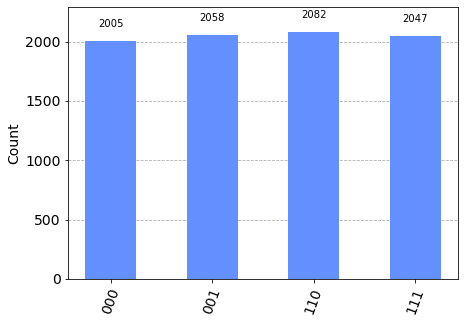

In [7]:
# Record start time
start = time.time()

simon_qc_trans = transpile(simon_qc, backend)
simon_qc_job = backend.run(simon_qc_trans, shots=8192)
simon_qc_output = simon_qc_job.result().get_counts()

# Record end time
end = time.time()
simon_qc_execute = end - start

print(simon_qc_output)
print("Execution time: ", simon_qc_execute)
plot_histogram(simon_qc_output)

### Classical Part for the simulator without noise  
### 1. Solve the system of linear equations y dot s = 0, 

In [8]:
# Print out the system of linear equations
for key in simon_qc_output:
    print(f"s dot product {key} = 0")

s dot product 001 = 0
s dot product 111 = 0
s dot product 000 = 0
s dot product 110 = 0


### 2. Find a single solution that is different from 000, and that is s. 

s = 110 which matches the 's' that we set at the beginning

### b. Use on a simulator with noise (Fake Provider Backends)

In [9]:
# Simulator with noise （Fake Simulator)
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import FakeVigo
provider = FakeVigo()
backend_noise = AerSimulator.from_backend(provider)

### Since the maximum number of qubits in this Noisy Simulator, we need to make sure the length of s satisfy the requirement

{'01': 4007, '11': 31, '10': 25, '00': 4129}
Execution time:  0.08628201484680176


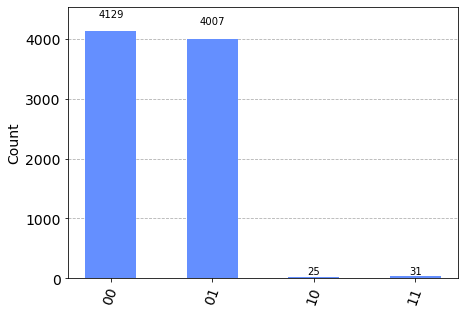

In [10]:
# Run the program on a noisy simulator
# Reset s and n
s = '10'
n = 2
simons_oracle_2 = simon_oracle(s, n)
simon_qc_2 = simon(simons_oracle_2, n)

# Record start time
start = time.time()

simon_qc_trans_noise = transpile(simon_qc_2, backend_noise)
simon_qc_job_noise = backend_noise.run(simon_qc_trans_noise, shots=8192)
simon_qc_output_noise = simon_qc_job_noise.result().get_counts()

# Record end time
end = time.time()
simon_qc_execute_noise = end - start

print(simon_qc_output_noise)
print("Execution time: ", simon_qc_execute_noise)
plot_histogram(simon_qc_output_noise)

### Classical Part for the simulator with noise  
### 1. Solve the system of linear equations y dot s = 0

In [11]:
# Print out the system of linear equations
for key in simon_qc_output_noise:
    print(f"s dot product {key} = 0")

s dot product 01 = 0
s dot product 11 = 0
s dot product 10 = 0
s dot product 00 = 0


### 2. Find a single solution that is different from 00, and that is s. 

Here we can't find the single solution from the system of these linear equations because the simulator has noise and it makes the circuit generate 'y' that doesn't satisfies y dot s = 0. In this case, they are 10 and 11 since their count is much lower than 00 and 01. 

Let's ignore the noisy measurement 10 and 11.

We can solve the linear equation s dot product 01 = 0 and get the single solution that is different from 00, and that is 10.

Hence, s = 10 which matches the 's' that we set at the beginning

## Step 4: Present one diagram that map the number of qubits to execution time

In [12]:
timeList = {}

# The function displayPlot is to calculate the execution time 
# for each number of qubits and for each kind of simulator and store them in timeList
# func: Function to geneate the Uf opeartion
# simulateType: "noise" or "no-noise" simulatior
# title: Title of the dot plot
def displayPlot(func, simulateType, title):
    execute_time = {}
    
    # Check what type of simulator is used
    if (simulateType == "noise"):
        provider = FakeVigo()
        backend = AerSimulator.from_backend(provider)
        qubitRange = range(1, 3)
    if (simulateType == "no-noise"):
        backend = Aer.get_backend('aer_simulator')
        qubitRange = range(1, 15)
    
    for n in qubitRange:
        # Generate 'a' with the length of n
        s = ''
        for i in range(n):
            bit = str(rd.randint(0, 1))
            s += bit
        
        oracle = func(s, n)
        qc = simon(oracle, n)

        # Record start time
        start = time.time()

        qc_trans = transpile(qc, backend)
        job = backend.run(qc_trans, shots=8192)
        output = job.result().get_counts()

        # Record end time
        end = time.time()
        execute = end - start

        execute_time[n] = execute
        
    timeList[title] = execute_time
    
    return

In [13]:
displayPlot(simon_oracle, "no-noise", "Execution time for different number of qubits in Simon's Oracle (No noise)")
displayPlot(simon_oracle, "noise", "Execution time for different number of qubits in Simon's Oracle (Noise)")

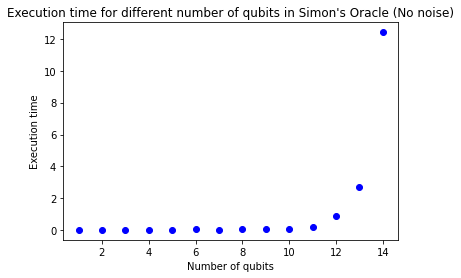

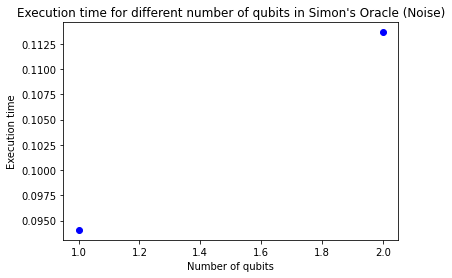

In [14]:
import matplotlib.pyplot as plt

for key in timeList:
    value = timeList[key]
    
    # Extract keys and values from the dictionary
    keys = list(value.keys())
    values = list(value.values())

    # Create a dot plot
    plt.scatter(keys, values, color='blue', marker='o')

    # Add labels and title
    plt.xlabel('Number of qubits')
    plt.ylabel('Execution time')
    plt.title(key)

    # Display the plot
    plt.show()